In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import scnym
import time
import os
import seaborn as sns
from os.path import join
import scipy.sparse as sps
import matplotlib.pyplot as plt

In [2]:
exp_id = 'MCAsubset'
binz = False
new_ident = 'no_new_identity'  # no_new_identity

In [3]:
data_root = '/home/yxh/data/MCA/scjoint/atlas_subset'

test_adata = sc.read_h5ad(join(data_root, 'adata_atac_cache.h5ad'))
train_adata = sc.read_h5ad('/home/yxh/gitrepo/multi-omics/Portal-main/cache/adata_rna_facs.h5ad')
test_adata.obs['cell_type_bkp'] = test_adata.obs.cell_type.values

if binz:
    train_adata.X = (train_adata.X>0).astype('float32')
    test_adata.X  = (test_adata.X>0).astype('float32')

In [4]:
print('%d cells, %d genes in the training set.' % train_adata.shape)
print('%d cells, %d genes in the target set.' % test_adata.shape)

19726 cells, 15519 genes in the training set.
57563 cells, 15519 genes in the target set.


In [5]:
# preprocess datasets
sc.pp.normalize_total(train_adata, target_sum=1e6)
sc.pp.log1p(train_adata)

sc.pp.normalize_total(test_adata, target_sum=1e6)
sc.pp.log1p(test_adata)

In [6]:
# set test data cells to the target data token `"Unlabeled"`
test_adata.obs["cell_type"] = "Unlabeled"
# concatenate training and test data into a single object
# for scNym
adata = train_adata.concatenate(test_adata)

In [7]:
# set test data cells to the target data token `"Unlabeled"`
test_adata.obs["cell_type"] = "Unlabeled"
# concatenate training and test data into a single object
# for scNym
adata = train_adata.concatenate(test_adata)

scnym.api.scnym_api(
    adata=adata,
    task="train",
    groupby="cell_type",
    config=new_ident,
    out_path=f"./scnym_outputs/{exp_id}_binz={binz}_{new_ident}",
)

In [8]:
scnym.api.scnym_api(
    adata=adata,
    task='predict',
    trained_model=f"./scnym_outputs/{exp_id}_binz={binz}_{new_ident}",
)

CUDA compute device found.


Finding cell types:   0%|                                                                                        | 0/76 [00:00<?, ?it/s]

Loaded model predicting 19 classes from 15519 features
['Astrocytes' 'B cell' 'Cardiomyocytes' 'Dendritic cell'
 'Endothelial cell' 'Enterocytes' 'Erythroblasts'
 'Hematopoietic stem cell' 'Hepatocytes' 'Kidney collecting duct cell'
 'Macrophages' 'Microglia' 'Monocytes' 'NK cell' 'Neuron'
 'Oligodendrocytes' 'T cell' 'Type I pneumocyte' 'Type II pneumocyte']
Building a classification matrix...
Gene names match exactly, returning input.
Predicting cell types...


Finding cell types: 100%|███████████████████████████████████████████████████████████████████████████████| 76/76 [00:47<00:00,  1.59it/s]


Extracting model embeddings...


In [9]:
# copy scNym predictions to the original test data embedding
test_adata.obs['scNym'] = np.array(adata.obs.loc[[x + '-1' for x in test_adata.obs_names], 'scNym'])  
train_adata.obs['scNym'] = np.array(adata.obs.loc[[x + '-0' for x in train_adata.obs_names], 'scNym'])

test_adata.obs['max_prob'] = np.array(adata.obs.loc[[x + '-1' for x in test_adata.obs_names], 'scNym_confidence'])
train_adata.obs['max_prob'] = np.array(adata.obs.loc[[x + '-0' for x in train_adata.obs_names], 'scNym_confidence'])

In [10]:
test_adata.obsm['X_scnym'] = adata[train_adata.shape[0]:].obsm['X_scnym'].copy()

In [11]:
from metrics import osr_evaluator

shr_mask = np.in1d(test_adata.obs.cell_type_bkp, train_adata.obs.cell_type.unique())

# test_acc = (test_adata.obs.scNym[shr_mask] == test_adata.obs.cell_type_bkp[shr_mask]).mean()
# train_acc = (train_adata.obs.scNym == train_adata.obs.cell_type).mean()

open_score = 1 - test_adata.obs['max_prob']

kn_data_pr = np.array(test_adata.obs['scNym'])[shr_mask]
kn_data_gt = np.array(test_adata.obs['cell_type_bkp'])[shr_mask]
kn_data_open_score = open_score[shr_mask]

unk_data_open_score = open_score[np.logical_not(shr_mask)]

closed_acc, os_auroc, os_aupr, oscr = osr_evaluator(kn_data_pr, kn_data_gt, kn_data_open_score, unk_data_open_score)
closed_acc, os_auroc, os_aupr, oscr

close_acc= 0.7802


(0.7801886628563487, -1, -1, -1)

In [ ]:
import umap
def umap_reduce(ad_smp, x_emb='raw'):
    reducer = umap.UMAP(n_neighbors=30,
                    n_components=2,
                    metric="correlation",
                    n_epochs=None,
                    learning_rate=1.0,
                    min_dist=0.3,
                    spread=1.0,
                    set_op_mix_ratio=1.0,
                    local_connectivity=1,
                    repulsion_strength=1,
                    negative_sample_rate=5,
                    a=None,
                    b=None,
                    random_state=1234,
                    metric_kwds=None,
                    angular_rp_forest=False,
                    verbose=False)
    embedding = reducer.fit_transform(ad_smp.X if x_emb=='raw' else ad_smp.obsm[x_emb])
    ad_smp.obsm["X_umap"] = embedding
    return ad_smp

In [39]:
test_adata = umap_reduce(test_adata, 'X_scnym')

/home/yxh/anaconda3/envs/scnym/lib/python3.8/site-packages/umap/nndescent.py:91: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../anaconda3/envs/scnym/lib/python3.8/site-packages/umap/utils.py", line 409:
@numba.njit(parallel=True)
def build_candidates(current_graph, n_vertices, n_neighbors, max_candidates, rng_state):
^

  candidate_neighbors = build_candidates(
/home/yxh/anaconda3/envs/scnym/lib/python3.8/site-packages/numba/core/typed_passes.py:313: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../

... storing 'mask' as categorical


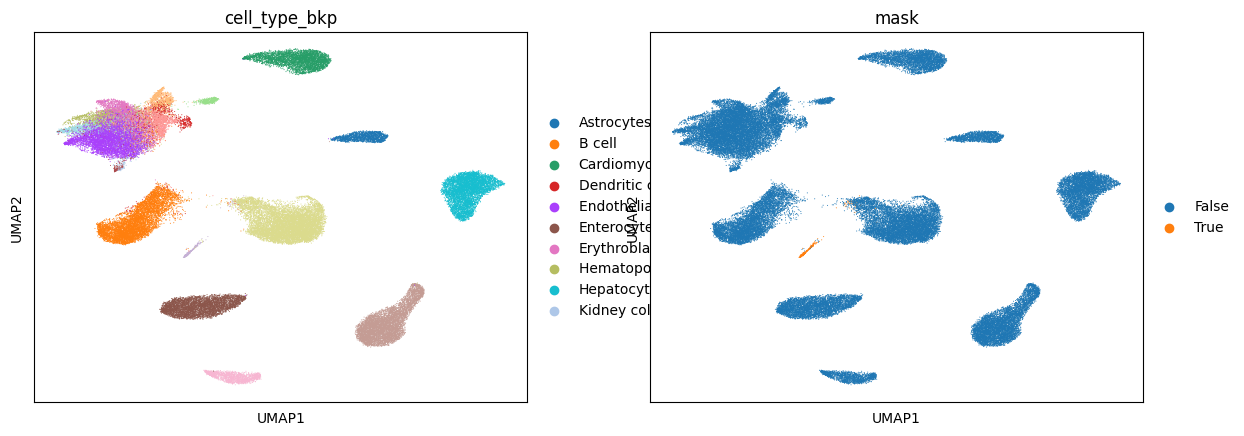

In [55]:
test_adata.obs['mask'] = [str(_) for _ in test_adata.obs.cell_type_bkp=='NK cell']
sc.pl.umap(test_adata, color=['cell_type_bkp', 'mask'])